# Welcome to the Observed Anomaly / Nino 3.4 Index demo!

This demo will take you from harvesting data from the IRI Data library to visualizing and modifying the data, then calculating the anomaly / index. 

In [75]:
#Importing relevant datasets and modules for the demo

import pandas as pd              #for Number manipulation
import numpy as np               #for DataFrames
import matplotlib.pyplot as plt  #for Visualization

obs = pd.read_csv('../Resources/ObsSST_demo.csv')  #Please make sure ObsSST.csv is downloaded and available at specified directory. 

## 1. What is the Nino 3.4 index? 

It is the seasonal Sea Surface Temperature Anomaly of the Nino 3.4 Region. 

In layman's terms, this means that if in usual years Nino 3.4 region was observed as 26°C in the JFM (Jan-March season)and this year, it was observed as 27 °C, then the anomaly of the 2025 JFM season would be 1 °C because anomaly is calculated as:

*Observed Anomaly = Expected SST - Observed SST*

## 2. What about calculating the Nino 3.4 index for Models? 

It must be noted that for models, we are not actually calculating the Nino 3.4 index because the Nino 3.4 index is only for observed data. 

But, we are essentially treating the model predictions as if the model prediction was the observed data for this season. This means:

*Model Anomaly = Expected SST - Model Prediction SST*

We'll be covering this in Demo 2 (soon to come)

## 3. How do we calculate the Expected SST?

This is also called the <b>seasonal climatology</b>

Let's say, for a base period of 1991-2020, the observed SSTs look like this:

(This data set was obtained from the ERSSTv5 dataset, available here: https://www.cpc.ncep.noaa.gov/data/indices/)

IRI Data Library also has a ERSST dataset available here: https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/index.html?Set-Language=en

### 3.1 Data Prep

In [76]:
obs

,YR,MON,NINO3.4
0,1990,11,26.81
1,1990,12,26.95
2,1991,1,27.03
3,1991,2,27.07
4,1991,3,27.32
...,...,...,...
359,2020,10,25.46
360,2020,11,25.28
361,2020,12,25.44
362,2021,1,25.55


Now, let's convert this dataset into a 3-month running average dataset

In [77]:
obs['NINO3.4_L3'] = obs['NINO3.4'].rolling(window=3, center=True).mean()
obs

,YR,MON,NINO3.4,NINO3.4_L3
0,1990,11,26.81,NaN
1,1990,12,26.95,26.930000
2,1991,1,27.03,27.016667
3,1991,2,27.07,27.140000
4,1991,3,27.32,27.466667
...,...,...,...,...
359,2020,10,25.46,25.543333
360,2020,11,25.28,25.393333
361,2020,12,25.44,25.423333
362,2021,1,25.55,25.580000


We can see that the monthly values have been converted into 3-month running average values, centered at the center month (Nov-Dec-Jan -> Dec)

Now, we will drop the top and bottom two rows, because we don't need them anymore. We will work with seasonal (3-month running average) SSTs from now on. We will also drop the Nino 3.4 column, because that's a monthly value. 


In [78]:
obs = obs.drop([obs.index[0], obs.index[1], obs.index[-1], obs.index[-2]])
obs = obs[['YR','MON','NINO3.4_L3']]
obs

,YR,MON,NINO3.4_L3
2,1991,1,27.016667
3,1991,2,27.140000
4,1991,3,27.466667
5,1991,4,27.843333
6,1991,5,28.153333
...,...,...,...
357,2020,8,26.380000
358,2020,9,25.870000
359,2020,10,25.543333
360,2020,11,25.393333


### 3.2 Calculation of Seasonal Mean (Seasonal Climatology)

Now that we have our seasonal data set, we want to average across the 30-years for each season and generate a 12-row dataframe containing the seasonal average SSTs for the Nino 3.4 region. These values are the *Expected SST* from Section 1

I am also adding labels as SZN for each of these rows. 

In [79]:
seasonal_obs = obs.groupby('MON')['NINO3.4_L3'].mean().reset_index() #this operation creates a new dataframe, seasonal_obs
seasonal_obs.rename(columns={'NINO3.4_L3': 'NINO3.4_SEASONAL'}, inplace=True)
month_to_season = {
    1: 'JFM',  2: 'FMA',  3: 'MAM',  4: 'AMJ',
    5: 'MJJ',  6: 'JJA',  7: 'JAS',  8: 'ASO',
    9: 'SON', 10: 'OND', 11: 'NDJ', 12: 'DJF'
}

# Map each MON in seasonal_obs to its season label
seasonal_obs['SZN'] = seasonal_obs['MON'].map(month_to_season)

# Make it a categorical column with a specified order -> this make sure Matplotlib plots JFM first and not DJF
season_order = ['JFM','FMA','MAM','AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']
seasonal_obs['SZN'] = pd.Categorical(seasonal_obs['SZN'], 
                                     categories=season_order, 
                                     ordered=True)

seasonal_obs

,MON,NINO3.4_SEASONAL,SZN
0,1,26.648667,JFM
1,2,26.859889,FMA
2,3,27.284667,MAM
3,4,27.678333,AMJ
4,5,27.826222,MJJ
5,6,27.651111,JJA
6,7,27.291667,JAS
7,8,26.955667,ASO
8,9,26.763333,SON
9,10,26.712556,OND


It's that simple! Now let's visualize this with MatPlotLib

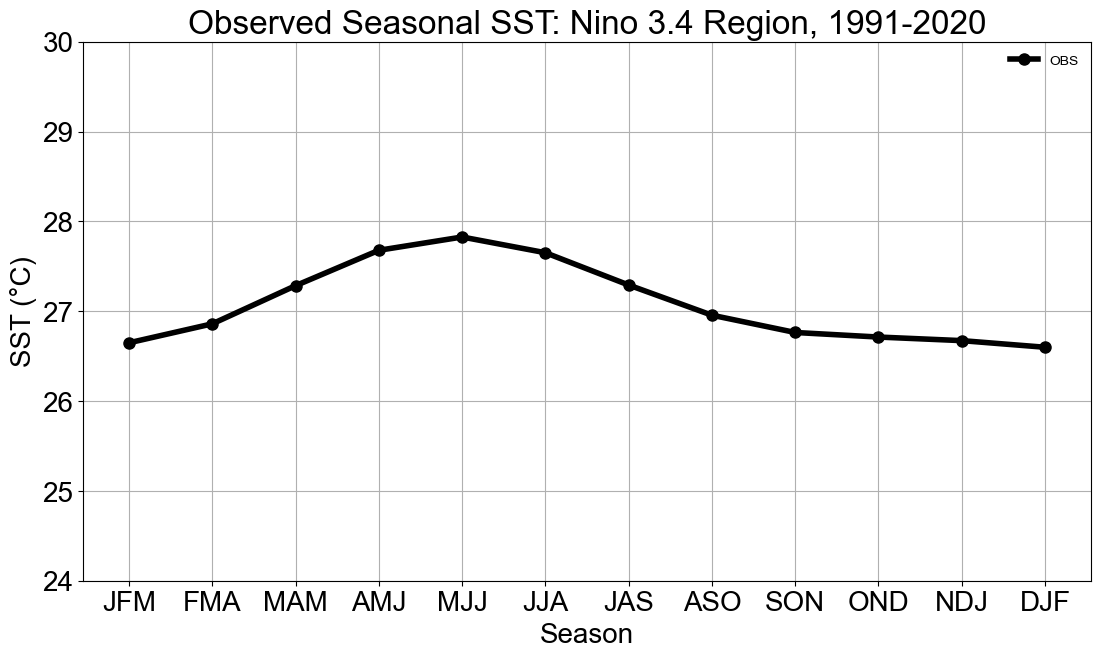

In [80]:
def seasonal_climatology():
    #rcParams and figsize come before plotting functions
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.figure(figsize=(13, 7))

    #plot however many as you'd like
    plt.plot(seasonal_obs['SZN'], seasonal_obs['NINO3.4_SEASONAL'], marker='o',markersize=8, linewidth=4, linestyle='-', color='black', label = 'OBS')
    
    #customize the plot
    plt.title(f'Observed Seasonal SST: Nino 3.4 Region, 1991-2020', size = 24)
    plt.xlabel('Season', size = 20)
    plt.ylabel('SST (°C)', size = 20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.grid(True)
    plt.legend(frameon=False)
    plt.ylim(ymin=24, ymax = 30)
    #plt.savefig(f'../Plots/Obs/seasonalClimatology.png', format='svg')
    
    #show the plot
    plt.show()
    
seasonal_climatology()


## 4. Calculation of Nino 3.4 Index

Recall our seasonal-scale observation dataset:

If something doesn't look right, click Run -> Run all cells 

In [81]:
obs

,YR,MON,NINO3.4_L3
2,1991,1,27.016667
3,1991,2,27.140000
4,1991,3,27.466667
5,1991,4,27.843333
6,1991,5,28.153333
...,...,...,...
357,2020,8,26.380000
358,2020,9,25.870000
359,2020,10,25.543333
360,2020,11,25.393333


We're going to use the monthly climatology we just calculated to label each monthly observation by anomaly. 

Remember that anomaly = expected (climatology) - observed (this instance)

In [82]:
obs_merged = obs.merge(
    seasonal_obs[['MON', 'NINO3.4_SEASONAL']],   # columns of interest
    on='MON',
    how='left',                                 # keep all rows from obs              
)
obs = obs_merged
obs.head(20) #we can see the first 20 rows, confirm that Nino 3.4 seasonal repeats every 12 seasons

,YR,MON,NINO3.4_L3,NINO3.4_SEASONAL
0,1991,1,27.016667,26.648667
1,1991,2,27.140000,26.859889
2,1991,3,27.466667,27.284667
3,1991,4,27.843333,27.678333
4,1991,5,28.153333,27.826222
5,1991,6,28.166667,27.651111
6,1991,7,27.943333,27.291667
7,1991,8,27.573333,26.955667
8,1991,9,27.416667,26.763333
9,1991,10,27.540000,26.712556


In [ ]:
obs['ANOM'] = obs['NINO3.4_SEASONAL'] -obs['NINO3.4_L3']
obs

Just like that, we calculated the monthly anomaly values for each month from 1991 to 2020 based on 1991-2020 climatology!